In [189]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import norm
import statsmodels.api as sm
from arch.unitroot import ADF
from statsmodels.discrete.discrete_model import Probit

In [498]:
DEFAULT_FIGSIZE = (48,18)
plt.rc("figure", figsize=DEFAULT_FIGSIZE)
plt.rc("font", size=48)

def plot(s, y=DEFAULT_FIGSIZE):
    #figsize(y=y)
    fig, ax = plt.subplots(1, 1)
    if isinstance(s, pd.Series):
        s.plot(ax=ax, legend=False, color=["orange"])
    else:
        s.plot(ax=ax, legend=False)
        fig.legend(frameon=False)
    
    ax.set_xlabel(None)
    ax.set_xlim(s.index[0], s.index[-1]) #s.index[0]
    sns.despine()
    fig.tight_layout(pad=1.0)
    #figsize()

In [40]:
## is a questionable decision to use dm: essentially stating forecast only lost if it lost really really badly

def diebold_mariano(loss_a, loss_b, nw_bandwidth,cv):
    delta = loss_a - loss_b
    mod = sm.OLS(delta, np.ones_like(delta))
    dm_res = mod.fit(cov_type="HAC", cov_kwds={"maxlags":int(nw_bandwidth)})
    av_diff = delta.mean()
    a  = dm_res.bse[0]
    dm_stat = float(av_diff / a)  

    #cv = norm.ppf(0.975)

    if dm_stat < (cv * -1):
        concl = 1
    else:
        concl = 0


    return concl

QUESTION 1
--

In [746]:
# Simulate some data
# run time ~ 1 minute

# True simulated data ## Sample size 100
rg = np.random.RandomState(100)

r = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
runs = 1000
true_100 = {}
size = 100
nw = size ** (1/3)
cv = norm.ppf(0.95)
theta_100 = []
dm_100 = []

for rho in r:
    print(rho)
    for run in range(runs):
        start = rg.normal(0,1/(1-(rho**2)))
        run_holder = []
        run_holder.append(start)

        for i in range(1,size):
            shock = rg.standard_normal()
            last_val = run_holder[-1]
            new_val = last_val * rho + shock
            run_holder.append(new_val)

        y = np.asarray(run_holder)

        # Fit using first half, tau//2
        mod = AutoReg(y[:size//2], lags=1, trend="c", old_names=False)
        res = mod.fit()

        # Full-sample model
        oos_mod = AutoReg(y, lags=1, trend="c", old_names=False)

        # One-step predictions
        oos_1step = oos_mod.predict(res.params)

        # OOS Random Walk predictions
        oos_rw = oos_mod.predict([0, 1])

        # Get second half of both
        # Use -tau//2: to get second half
        oos_1step = oos_1step[-size//2:]
        oos_rw = oos_rw[-size//2:]

        # Calculate the losses
        loss_1step = (oos_1step - y[-size//2:]) ** 2
        loss_rw = (oos_rw - y[-size//2:]) ** 2

        evaluation = (loss_1step - loss_rw).sum()

        if evaluation > 0:
            mark = 1
        else:
            mark = 0

        # Append the estimated thetas and the DM results into lists
        theta_100.append(res.params[1])
        dm_100.append(mark)

        #dm_100.append(diebold_mariano( loss_rw, loss_1step, nw, cv))

theta_100 = np.asarray(theta_100)
dm_100 = np.asarray(dm_100)

0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


In [748]:
# Proportion of fails:
np.mean(loss_1step)

1.0387351234899809

In [660]:
app_dist = pd.DataFrame([theta_100,dm_100]).T
app_dist.columns = ["Theta^", "DM res"]

sampled_theta = []
sampled_dm = []

# two number multiply to give total runs * rho
for i in range(100):
    start = i * 100
    end = (i + 1) * 100
    sampled_theta.append(app_dist["Theta^"][start:end].mean())
    sampled_dm.append(app_dist["DM res"][start:end].mean())

sampled_theta = np.asarray(sampled_theta)
sampled_dm = np.asarray(sampled_dm)

app_dist = pd.DataFrame([sampled_theta,sampled_dm]).T
app_dist.columns = ["Theta^", "DM res"]

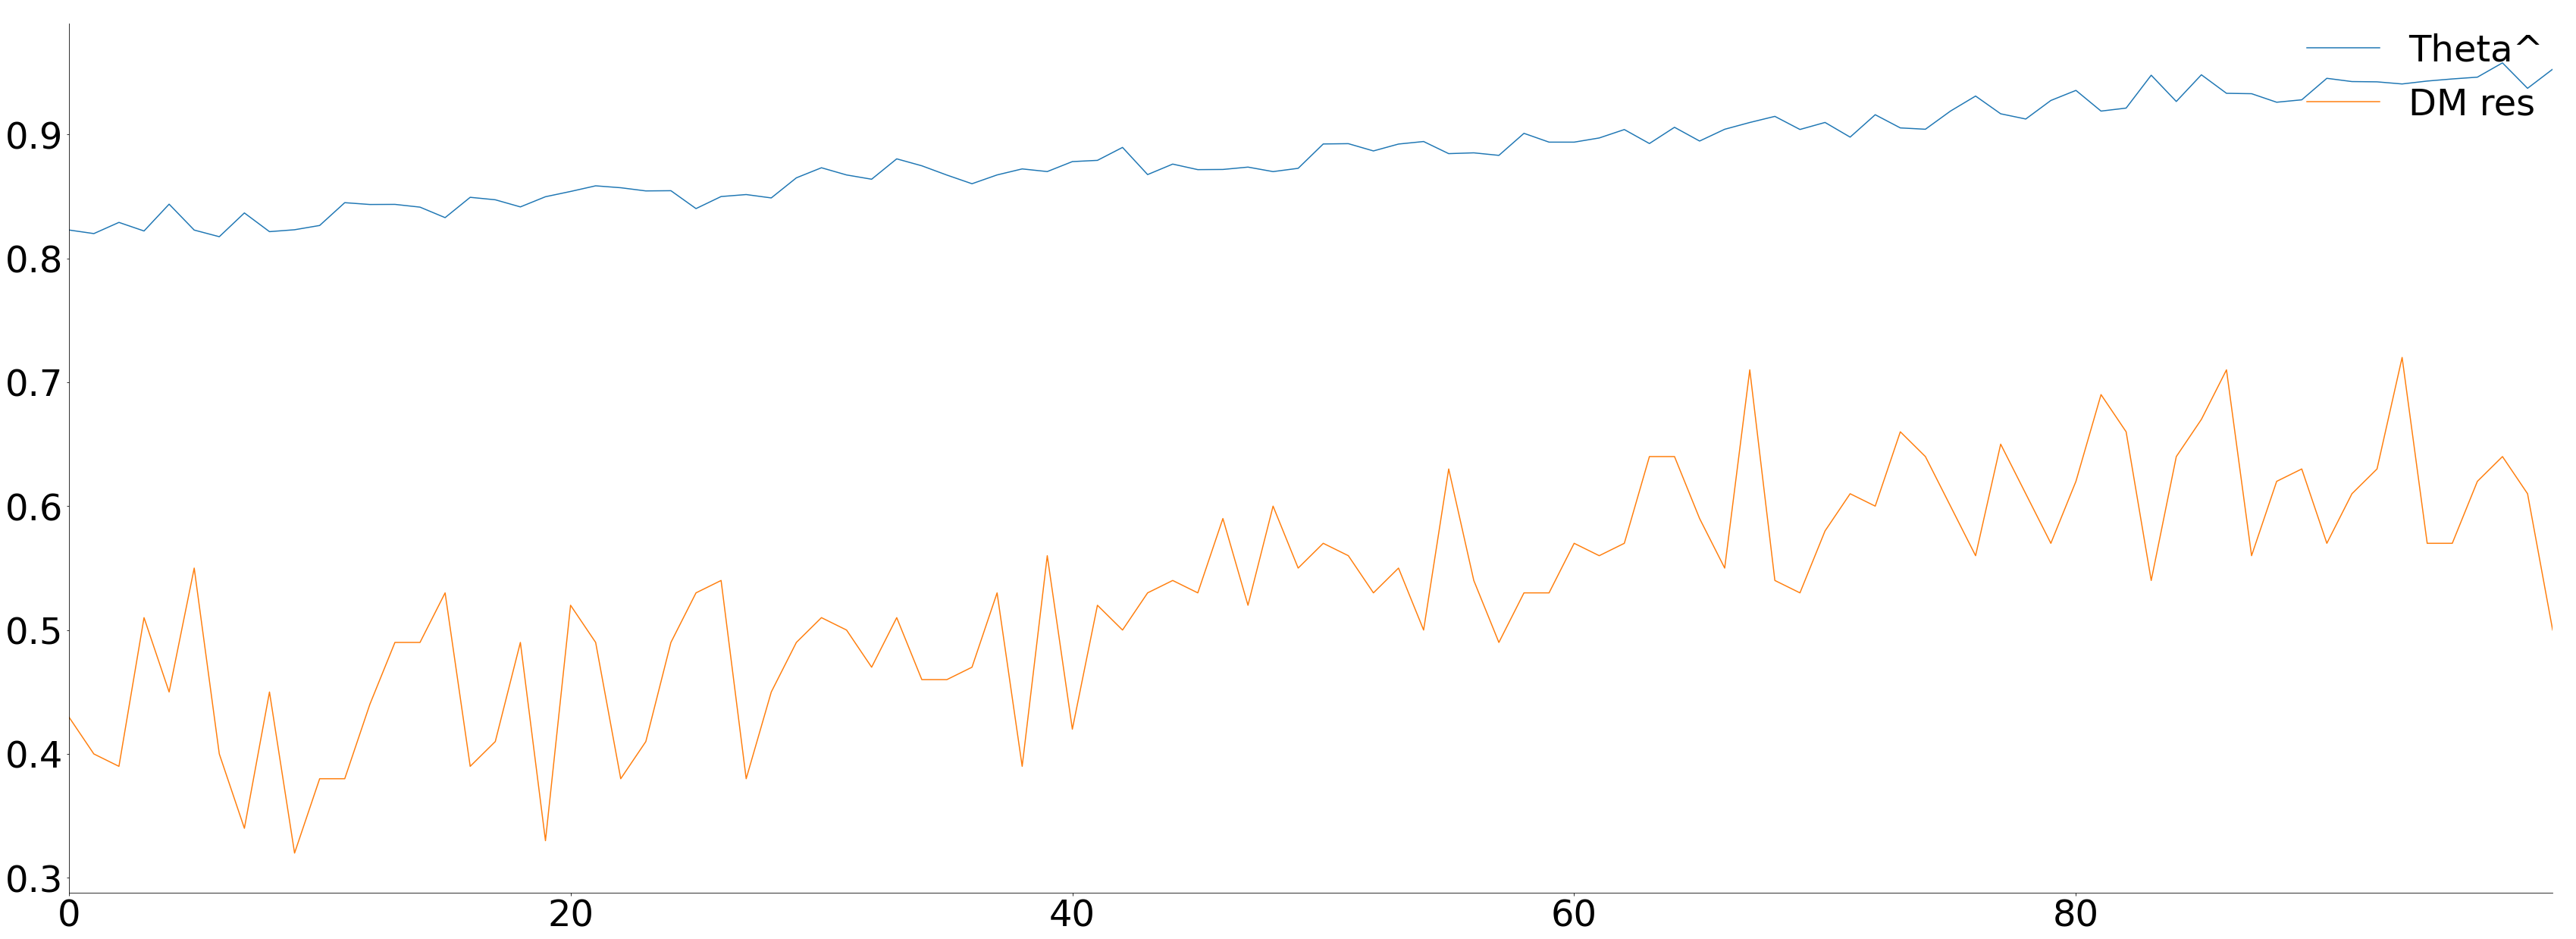

In [661]:
plot(app_dist)

In [622]:
sort_app_dist = app_dist.sort_values("Theta^")
sort_app_dist.index = range(100)
#plot(sort_app_dist)

In [627]:
# What I think the Germans have done to estimate the value of theta above which we should take a random walk

sort_app_dist[31:35]

,Theta^,DM res
31,0.864952,0.49
32,0.867180,0.46
33,0.867282,0.50
34,0.867292,0.53


-------

------

In [699]:
# 3. PROBIT MODEL

model = Probit(dm_100, sm.add_constant(theta_100))
probit_model = model.fit()
probit_model.summary()

Optimization terminated successfully.
         Current function value: 0.669659
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                         Probit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Fri, 12 Mar 2021   Pseudo R-squ.:                 0.03102
Time:                        13:39:00   Log-Likelihood:                -6696.6
converged:                       True   LL-Null:                       -6911.0
Covariance Type:            nonrobust   LLR p-value:                 2.995e-95
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9240      0.143     20.488      0.000       2.644       3.204
x1            -3.2036      0.160    -20.061      0.000      -3.517      -2.891
==============================================================================
"""

In [487]:
# Average marginal effect of theta on the probability at each observation
probit_model.get_margeff(at="overall", method='dydx', atexog=None, dummy=False, count=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.2306      0.057    -21.426      0.000      -1.343      -1.118
==============================================================================
"""

In [488]:
# function expressing the probability of a dm rejection in terms of the estimated
norm.cdf(probit_model.params[0] + theta_100 * probit_model.params[1])

array([0.58762223, 0.48462291, 0.61536333, ..., 0.3912712 , 0.39830615,
       0.60986504])

In [700]:
# function expressing the probability of a dm rejection in terms of the estimated
print(norm.cdf(probit_model.params[0] + theta_100 * probit_model.params[1]))

# Value of theta at which it is better to approximate the distribution with a random walk
(norm.ppf(0.5) - probit_model.params[0]) / probit_model.params[1]

[0.58762223 0.48462291 0.61536333 ... 0.3912712  0.39830615 0.60986504]


0.9127076166762589

In [491]:
np.max(probit_model.predict())

0.9732586363946166

In [335]:
np.mean(dm_100)

0.35579

QUESTION 2
--

In [445]:
# Simulate some data
# run time ~ 1 minute

# True simulated data ## Sample size 100
rg = np.random.RandomState(100)

r = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
runs = 1000
size = 100
nw = size ** (1/3)
cv = norm.ppf(0.975)
theta_100_2 = []
dm_100_2 = []

for rho in r:
    print(rho)
    for run in range(runs):
        start = rg.normal(0,1/(1-(rho**2)))
        run_holder = []
        run_holder.append(start)

        for i in range(1,size):
            shock = rg.standard_normal()
            last_val = run_holder[-1]
            new_val = last_val * rho + shock
            run_holder.append(new_val)
            
        y = np.asarray(run_holder)

        # Fit using first half, tau//2
        mod = AutoReg(y[:size//2], lags=1, trend="c", old_names=False)
        res = mod.fit()

        # Full-sample model
        oos_mod = AutoReg(y, lags=1, trend="c", old_names=False)

        # OOS Random Walk predictions
        oos_rw = oos_mod.predict([0, 1])

        ## ADF test, and forecasting
        adf = ADF(y[-size//2:]).pvalue

        if adf > 0.05:
            oos_1step = oos_rw
            
        else:
            oos_1step = oos_mod.predict(res.params)


        # Get second half of both
        # Use -size//2: to get second half
        oos_1step = oos_1step[-size//2:]
        oos_rw = oos_rw[-size//2:]

        # Calculate the losses
        loss_1step = (oos_1step - y[-size//2:]) ** 2
        loss_rw = (oos_rw - y[-size//2:]) ** 2

        evaluation = (loss_1step - loss_rw).sum()

        if evaluation > 0:
            mark = 1
        else:
            mark = 0

        # Append the estimated thetas and the DM results into lists
        theta_100_2.append(res.params[1])
        dm_100_2.append(mark)




0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


In [463]:
print("% of runs where the forecast is beaten by a random walk (where a rw has not been preselected")
print(f" {np.mean(dm_100_2) * 100}%")
print()
print("Compared to previously:")
print(f"{np.round(np.mean(dm_100)*100,3)}%")
print()
print("Huge Improvement")

% of runs where the forecast is beaten by a random walk (where a rw has not been preselected
 5.56%

Compared to previously:
41.94%

Huge Improvement


Question 3
---

In [ ]:
# 1. modify LASSO / RIDGE
# 2. estimate the difference and apply LASSO
# 3. implement my own version of shrinkage

In [749]:
""" Second Method"""

# True simulated data ## Sample size 100
rg = np.random.RandomState(100)

r = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
runs = 1000
size = 100
nw = size ** (1/3)
cv = norm.ppf(0.975)
theta_100_3 = []
dm_100_3 = []

for rho in r:
    print(rho)
    for run in range(runs):
        start = rg.normal(0,1/(1-(rho**2)))
        run_holder = []
        run_holder.append(start)

        for i in range(1,size):
            shock = rg.standard_normal()
            last_val = run_holder[-1]
            new_val = last_val * rho + shock
            run_holder.append(new_val)
            
        y = pd.Series(run_holder)
        y_diff = y.diff()

        # Fit using first half, size//2
        x = sm.add_constant(y_diff.shift(1).dropna()[:size//2-1])
        dep = y_diff[2:].dropna()[:size//2-1]

        res = sm.OLS(dep,x).fit()
        a, b = res.params

        mod = AutoReg(y[:(size//2)-1], lags=1, trend="c", old_names=False)
        theta = mod.fit().params[1]
        #res = mod.fit()

        # Full-sample model
        oos_mod = AutoReg(y, lags=1, trend="c", old_names=False)

        # OOS Random Walk predictions
        oos_rw = oos_mod.predict([0, 1])

        # Model forecasts
        #oos_1step = oos_mod.predict(res.params)
        #oos_1step = res.params * y_diff

        est = []
        for i in range(1,99):
            t_1 = y[i-1]
            t_2 = y_diff[i-1]
            est.append(t_1 + a + (b) * t_2 ) 
        oos_1step = np.asarray(est)


        # Get second half of both
        # Use -size//2: to get second half
        oos_1step = oos_1step[-(size//2):]
        oos_rw = oos_rw[-size//2:]

        # Calculate the losses
        loss_1step = (oos_1step - y[-size//2:]) ** 2
        loss_rw = (oos_rw - y[-size//2:]) ** 2

        evaluation = (loss_1step - loss_rw).sum()

        if evaluation > 0:
            mark = 1
        else:
            mark = 0

        # Append the estimated thetas and the DM results into lists
        theta_100_3.append(theta)
        dm_100_3.append(mark)

theta_100_3 = np.asarray(theta_100_3)
dm_100_3 = np.asarray(dm_100_3)


0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


In [753]:
loss_rw.mean()

1.1209960348883043

In [750]:
loss_1step.mean()

2.1279039747706103

In [722]:
theta_100_3

array([0.85513225, 0.9273263 , 0.8219334 , ..., 0.99867492, 0.98852632,
       0.81769276])

In [751]:
# 3. PROBIT MODEL

model = Probit(dm_100_3, sm.add_constant(theta_100_3))
probit_model = model.fit()
probit_model.summary()

Optimization terminated successfully.
         Current function value: 0.002699
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                         Probit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Fri, 12 Mar 2021   Pseudo R-squ.:                 0.01268
Time:                        14:07:08   Log-Likelihood:                -26.988
converged:                       True   LL-Null:                       -27.335
Covariance Type:            nonrobust   LLR p-value:                    0.4051
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9816      2.051      2.429      0.015       0.963       9.001
x1            -1.7173      2.232     -0.770      0.442      -6.091       2.656
==============================================================================
"""

In [752]:
# function expressing the probability of a dm rejection in terms of the estimated
print(norm.cdf(probit_model.params[0] + theta_100 * probit_model.params[1]))

# Value of theta at which it is better to approximate the distribution with a random walk
(norm.ppf(0.5) - probit_model.params[0]) / probit_model.params[1]

[0.99979445 0.99965495 0.99982245 ... 0.99945498 0.99947353 0.99981716]


2.900763066115131

In [702]:
probit_model.params[1]

-3.2036343928270465

In [607]:
print("% of runs where the forecast is beaten by a random walk (where a rw has not been preselected")
print(f" {np.mean(dm_100_3) * 100}%")
print()
print("Compared to previously:")
print(f"{np.round(np.mean(dm_100)*100,3)}%")
print()
print("Not good")

% of runs where the forecast is beaten by a random walk (where a rw has not been preselected
 60.39%

Compared to previously:
53.2%

Not good
